Introduction

The task is to analyse the sentiment of Twitter data for one of the major U.S. airline. The dataset has been taken from Kaggle. There are 3 sentiments we can see in this dataset(positive, negative and neutral). My task is to find out/classify the  twitter sentiments.

It is  to be implemented using ULMFiT model. ULMFiT is a transfer learning model developed by Jeremy Howard and Sebastian Ruder.  Transfer Learning is quite common in Computer Vision as the pretrained model could extract the basic features while training from huge datasets. There are pretrained models  like word2vec, GLoVe in NLP, but they are primarily use to analyse only the first layer of neural network. The rest of the model still needs to be trained from scratch and requires huge number of training examples . The fast.ai team proposed an effective transfer learning method(ULMFiT), that could be applied to any task in NLP, and introduced techniques that are key to train a language model. Furthermore, ULMFiT  works very well with small dataset.



In [0]:
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
#!pip install fastai  

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [75]:
# uploading files
from google.colab import files
uploaded = files.upload()

Saving database.sqlite to database (1).sqlite


In [76]:
uploaded = files.upload()

Saving Tweets.csv to Tweets (1).csv


In [0]:
# reading csv file to dataframe
import io
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

In [138]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


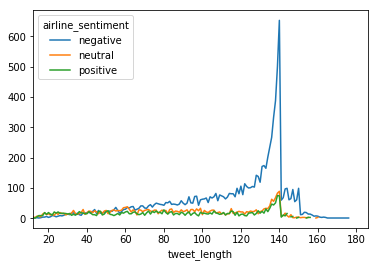

In [139]:
# relation between tweet length and airline_sentiment
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

The 'tweet_length' and 'sentiment' column does not have much correlation, besides the fact that for negative comment, tweet length is more.  

In [140]:
# spearman correlation to find out relation between numerical variables
df.corr(method='spearman')

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count,tweet_length
tweet_id,1.000000,0.017550,0.009536,-0.016962,0.038863
airline_sentiment_confidence,0.017550,1.000000,0.646059,0.051118,0.156290
negativereason_confidence,0.009536,0.646059,1.000000,0.042640,0.135210
retweet_count,-0.016962,0.051118,0.042640,1.000000,0.069543
tweet_length,0.038863,0.156290,0.135210,0.069543,1.000000


Other features does not have any significant correlation as well. So, we will consider 'text' column to predict airline sentiment.

In [0]:
# dataframe with our data of interest 
df1 = df[['airline_sentiment','text']].copy()


In [142]:
df1.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


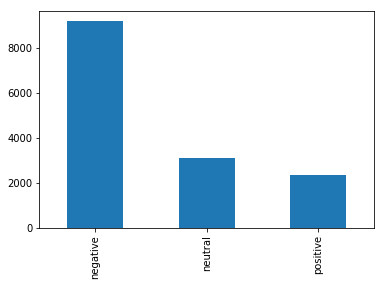

In [143]:
df1['airline_sentiment'].value_counts().plot(kind='bar')

The dataset seems to be imbalanced with more negative comments compared to neutral and positive comments

In [144]:
df1['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [0]:
# cleaning the text using regular expressions, deleting everything other than alphabets
df1['text'] = df1['text'].str.replace("[^a-zA-Z]", " ")

In [146]:
df1.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you ve added commercials t...
2,neutral,VirginAmerica I didn t today Must mean I n...
3,negative,VirginAmerica it s really aggressive to blast...
4,negative,VirginAmerica and it s a really big bad thing...


In [0]:
# saving dataframe to csv
df1.to_csv('texts.csv',index=False, encoding='utf-8')


In [148]:
df2 = pd.read_csv('texts.csv')
df2.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you ve added commercials t...
2,neutral,VirginAmerica I didn t today Must mean I n...
3,negative,VirginAmerica it s really aggressive to blast...
4,negative,VirginAmerica and it s a really big bad thing...


In [0]:
from sklearn.model_selection import train_test_split

#split data into training and validation set
df_trn, df_val = train_test_split(df2, stratify = df2['airline_sentiment'],test_size = 0.4, random_state = 12)

In [150]:
# shape of training and validation data
df_trn.shape, df_val.shape

((8784, 2), (5856, 2))

Language Modelling:

A language model attempts to learn the structure of natural language through heirarchical representations, and contains both low level features(word representations) as well as high level features(semantic meaning)

Semisupervised Learning: 

Trnasfer Learning is done in multi step process- where entire network is first pre-trained in an unsupervised manner for language modellig and it is followed by supervised fine tuning called as semi-supervised learning.

In [0]:
# Data preparation for language model and classification model using fast.ai library
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
#data_lm = TextLMDataBunch.from_csv(path = "",'texts.csv' )

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)
#data_clas = TextClasDataBunch.from_csv(path = "",vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_lm.save()

In [153]:
data_lm.show_batch()


idx,text
0,delayed again and again computer down xxbos jetblue just mine sadly xxmaj but yea the fly fi is awesome xxbos jetblue sent curious to see what kind of comp we get xxbos united xxmaj how much is baggage check for xxmaj international flights xxbos americanair that s not the point xxmaj say its at the counter when i clearly see on your site xxup aa agent was a loss words
1,xxbos united we just almost had a major accident on ua xxmaj how about passing on some information to those of us waiting on plane xxbos americanair ok so why is it xxmaj late xxmaj flight xxmaj and for that matter why was my flight xxmaj cancelled xxmaj flighted this morning i ve been in xxup yyz since xxup am xxbos southwestair awesome thank you xxbos usairways thanks however i
2,us know what you think http t co xxunk xxbos jetblue xxmaj thanks for the credit because of the hr delay i can tell customer service means a lot to xxup you xxmaj thankful xxbos united i m xxunk not i fly or service every week and i m just unhappy spend too much money to be unhappy xxbos united overbooked by xxup xxunk people the worst xxbos southwestair what
3,people on my flight have xxunk xxunk xxbos americanair you bet make this screw up right for once xxmaj things i need in bag for my job and you have grounded me today xxunk xxbos southwestair may want to direct that to the people at xxunk xxunk xxbos united xxmaj please help i am in xxmaj ethiopia adopting a two year old child xxmaj have an existing confirmation xxmaj need
4,xxunk over xxmaj frankfurt xxmaj is everything ok xxbos usairways flight delayed for hours for a deadhead crew xxmaj lets make paying customers wait that is great service usairways xxbos united received hotel but no food xxmaj also email for miles xxmaj last trip had hr delay and miles so less for xxmaj cancelled xxmaj flightlation xxbos southwestair xxmaj why can t i find a cheap flight from xxup dc


Architecture that ULMFIT uses for its language modeling task is AWD-LSTM. Its an abbreviation for ASGD Weight-dropped LSTM. It has dropout at various possible layers. They are:

1. Encoder Dropout: Zeroing embedding vectors randomly.
2. Input Dropout: Zeroing embedding lookups outputs randomly.
3. Weight Dropout: Apply dropout to LSTM weights.
4. Hidden dropputs: Zeroing outputs of LSTM layers. It is applied except for last layer LSTM output.

ULMFIT involves fine tuning a  pre-trained language model(LM), trained on Wikitext 103 dataset, to a new dataset in such a manner that it does not forget what is learned previously.




In [0]:
# data_lm created earlier used to fine tune a pre-trained language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)


In [155]:
# training the learner object with learning rate of 1e - 2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.993234,5.007825,0.168335,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


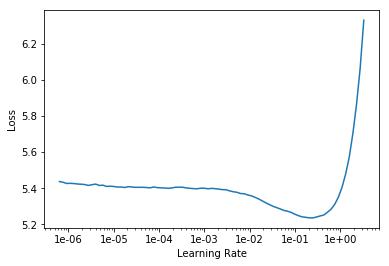

In [156]:
# finding the correct learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# saving the encoder for classification
learn.save_encoder('ft_enc')

In [0]:
# using data_clas object to build a classifier with our fine tuned model
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


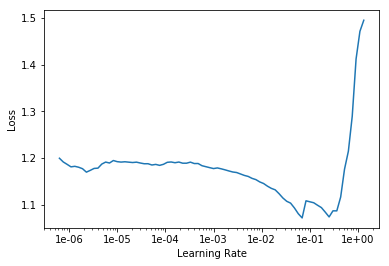

In [160]:
learn.lr_find()
learn.recorder.plot()

In [161]:
# fitting the model again
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.820018,0.732873,0.670765,00:09


The accuracy has significantly improved and validation loss also reduced significantly.

Further fine tuning the classifier

Gradual unfreezing  avoids aggressive fine-tuning, which leads to catastrophic forgetting, and cautious fine-tuning, which leads to slow convergence. Gradual fine-tuning means last layer is unfrozen, and then fine-tune all unfrozen layers for one epoch. Then next frozen layer is unfrozen and training repeated. It is done untill convergence is attained.

In [162]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.822802,0.665581,0.717213,00:10


In [163]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.714745,0.617121,0.744194,00:18


In [165]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.653287,0.543592,0.780055,00:17


In [166]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2/(2.6**8),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.627691,0.521440,0.796448,00:17


In [168]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2/(2.6**10),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.602765,0.520689,0.798839,00:18


In [164]:
# get predictions from the validation set out of the learner object

preds,targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions,targets)

col_0,0,1,2
row_0,,,
0,3494,782,362
1,90,374,93
2,87,84,490


References

1. https://arxiv.org/pdf/1708.02182.pdf
2. https://arxiv.org/abs/1801.06146
3. http://nlp.fast.ai/
4. https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde
5. https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/
